##For faster segmentation select 'GPU' under 'Edit' -> 'Notebook Settings' -> 'Hardware accelerator'.

In [ ]:
import torch
import torchvision
import sys
import os
os.chdir('/content')
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

!{sys.executable} -m pip install npsam

from npsam import *

Upload the image(s) to to the content folder and set a pathname called `filepath` to a file or a folder of the filetype .png, .jpg, .jpeg, .tif, .tiff (either an absolute or relative pathname)

In [3]:
filepath = '/content/Sample_images/Ag_HAADF.png'

In [ ]:
filepath = '/content/Sample_images'

Call the `SAM` function from `NPSAM.py` to get masks from the image. The function takes a filepath as the first argument and the following keyword arguments:<br> 
 - `device` (str): Can be either `cuda` or `cpu` (`default='cpu'`). <br>
 - `PPS` (int): Sets the sampling gridsize for the image (`default=64`). <br>
 - `SAM_model` (str): Chooses which SAM weights to use. Can either be `'f'` for [FastSAM](https://github.com/CASIA-IVA-Lab/FastSAM), `'h'` for huge, `'l'` for large, `'b'` for base or `'auto'` which chooses the largest of the three regular SAM weights availabe. (`default='auto'`) <br>
 - `shape_filter` (bool): Removes faulty masks for a better and faster experience. However, for concave NPs it might cause problems (`default=True`) <br>
 - `min_masks_region_area` (int): Sets the minimum mask area in pixels. Makes SAM faster but will miss NPs smaller than threshold (`default=35`) <br>
 - `crop_and_enlarge` (bool): If `True`, it crops the image into 4 slightly overlapping parts that are also zoomed in (e.g., a 512x512 image is cropped to 4 680x680 images (340x340 before zoom), and runs SAM on all 4. Afterwards, the masks are stiched back together (`default=False`). <br>
 - `invert` (bool): If `True`, the image is inverted before running SAM. The masks are saved as usual (`default=False`). <br>
 - `double` (bool): If `True`, the original and inverted image will be segmented and stitched together. <br>
 - `**kwargs`: More key word arguments can be applied see [documentation](https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py#L35) of the model.

When executing `SAM` a folder `<filename>_files` is created next to the file(s).

In [3]:
SAM(filepath, device='cuda', PPS=64, SAM_model='h')

433 masks found. It took 35 seconds


If `SAM` has already been executed once it is not necessary to segment the image again, as the masks have previously been saved in the folder `<filename>_files`, that it unless you want to redo it with other parameters.

For a quick visualisation images and masks can be plotted.

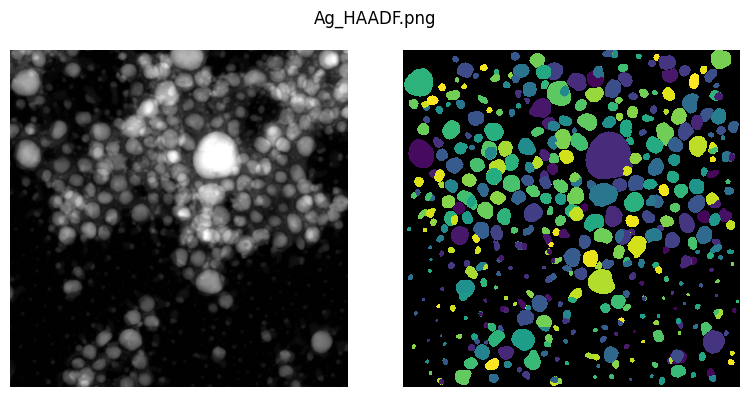

In [4]:
mask_plot(filepath)

Instead of using `SAM`, segmentation from elsewhere (e.g. ImageJ) can be imported with `ìmport_segmentation()`. This way, the interactive filtering GUI can be used on anyones favourite segmentation method.
The segmentation from elsewhere must be stored as a black and white image (.png, .jpg or .tif). The filepath(s) pointing to these segmentation images can be given as a str with the `seg_filepath` keyword argument (`default=None`). If `seg_filepath=None`, it will prompt the user to select the segmentation image. <br>
The function can be run as: <br>
`import_segmentation(filepath)`

***
The function `properties()` from `NPSAM.py`will create a pandas dataframe that contains properties of each mask from the `scikit-image` library `regionprops` for more [infomation](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops).<br>
The function takes the arguments: <br>
 - `scaling` (bool/int/float/list): If `True`, it prompts the user to apply a scaling in pixels pr nm. Can also take a fraction: Therefore, if the image has a $50$ nm scalebar measuring $400$ pixels a scale can be given as $400/50$. If an int or float is given, the value will be used for the image(s). If the images have different scalings, the scalings can be given as a list.
For multiple files a specific scaling can be given for eack file or the same for all. (`default=True`)<br>
 - `stepsize` (int): Sets the step size such that the function will traverse the array of masks faster. With increasing stepsize the faster the function will run. However, be cautious to not increase the step size too much for images with small NPs (`default=1`).

The initial properties are saved as a csv file called `<filename_raw_dataframe.csv`.

In [4]:
properties(filepath, scaling=True)

The following scalings will be used for the given images:
2.0 pixel pr nm for Ag_HAADF.png
Finding mask properties in Ag_HAADF.png:
Mask 433/433
Detecting areas with overlap. Done.
Processing areas with overlap:
Area 92/92
Done. It took 11 seconds.


### Non-GUI filtering
If the interactive GUI in not preferable filter conditions can be applied manually.

Manual filter conditions must be given as a dictionary. If there are more images, the dictionary will be used on all images. It is also possible to pass a list of dictionaries where each dictionary determines the filtering conditions for each image.<br>
The possible filtering dictionary keys are:<br>
`'min_area'`: minimum area,<br>
`'max_area'`: maximum area,<br>
`'min_solidity'`: minimum solidity (`default = 0`),<br>
`'max_solidity'`: maximum solidity (`default = 1`),<br>
`'min_intensity'`: minimum intensity,<br>
`'max_intensity'`: maximum intensity,<br>
`'min_eccentricity'`: minimum eccentricity (`default = 0`),<br>
`'max_eccentricity'`: maximum eccentricity (`default = 1`),<br>
`'overlap'`: maximum overlap,<br>
`'overlapping_masks'`: number of overlapping masks,<br>

As an example, we can make a simple area filter:

In [7]:
conditions = {'max_area':500}

In [8]:
manual_filter(filepath, conditions)

Conclusively, an overview can be made with said function. For each image, it plots the orignal image, the masks found, an area histogram and which parameters was used to filter the masks. This is saved as a pdf called `<filename>_overview.pdf`. Another pdf called `NPSAM_overview.pdf` is saved in the parent folder. It contains summed histograms of the properties given in `property_list` as well as overview(s) for the image(s) segmented.

In addition to `filepath`, the `overview()` function takes the arguments:
 - `property_list` (list) which specifies which properties histograms should be created for (`default=['area']`). Possible properties are:
   - 'all' (will give statistics of all the properties)
   - 'area'
   - 'convex area'
   - 'eccentricity'
   - 'solidity'
   - 'intensity'
   - 'overlap'
   - 'diameter'
   - 'max diameter'
   - 'orientation'
   - 'perimeter'
   - 'crofton perimeter'
 - `bin_list` (list/None) which is a list of the number of bins that the histogram for each property in `property_list` should have. If left at (`default=None`), the function tries to guess a reasonable bin size.
 - `timestamp` (bool) if `True` the `NPSAM_overview.pdf` will get a timestamp `NPSAM_overview_<YYYYMMDDHHMMSS>.pdf`. This is to prevent overwriting. (`default=False`).
 In each histogram plot there is a box with statistical values:
### Statistical Parameters
- **Mean**: The average of all data points.
- **Standard Deviation (Std Dev)**: Measures the amount of variation or dispersion in a set of values.
- **Median**: The middle value in the data set, dividing it into two halves.
- **Variance**: Measures how far each number in the set is from the mean and thus from every other number in the set.
- **Coeff of Variation**: A standardized measure of dispersion of a frequency distribution.
- **Skewness**: Measures the asymmetry of the probability distribution of a real-valued random variable about its mean.
- **Kurtosis**: Measures the "tailedness" of the probability distribution.
- **Count**: The total number of data points.
- **Sum**: The total sum of all data points.
- **Interquartile Range (IQR)**: Measures the statistical dispersion and is calculated as the difference between the 75th and 25th percentiles.
- **Lower Quantile**: The value below which a given percentage of observations in a group of observations falls (25th percentile).
- **Upper Quantile**: The value above which a certain percent of observations fall (75th percentile).
- **Minimum (Min)**: The smallest value in the data set.
- **Maximum (Max)**: The largest value in the data set.
- **Range**: The difference between the highest and lowest values.


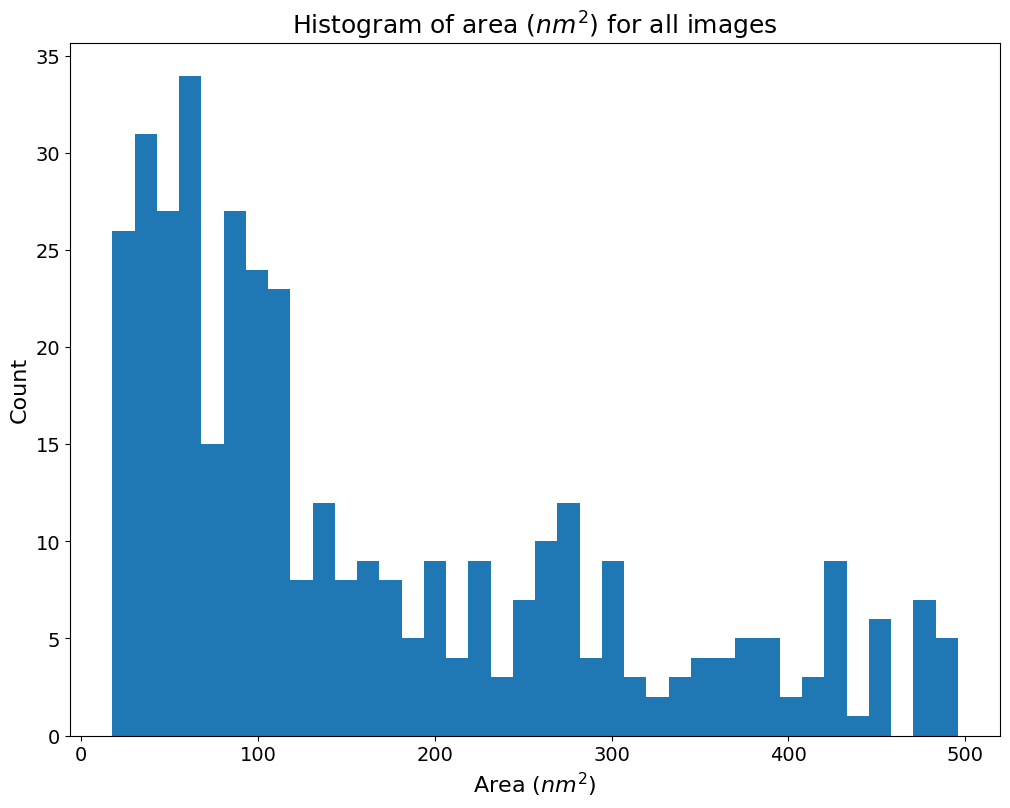

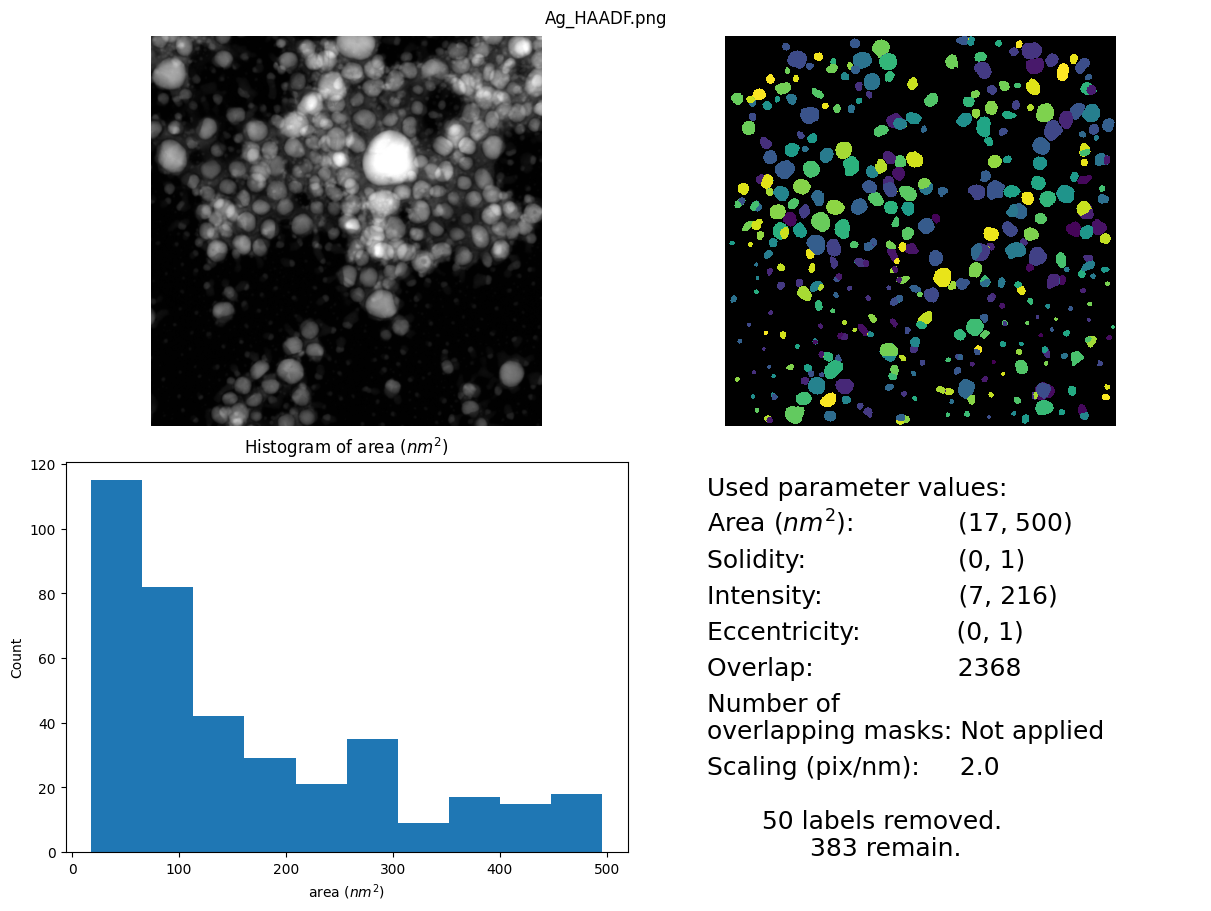

In [9]:
property_list = ['area','diameter','solidity']
overview(filepath, property_list)